In [54]:
import tensorflow as tf
import keras as k
from keras.layers import Bidirectional, LSTM, Dense, Input
from keras.models import Model
from keras import optimizers
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import pandas as pd
import pickle as pkl
from tqdm import tqdm
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pdk
from tqdm import tqdm
from multiprocessing import Pool
from datetime import datetime

#from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from sklearn.metrics import mean_squared_log_error, mean_squared_error
import re
import datetime

from keras.models import *
from keras.layers import *
from keras.layers.core import Lambda
from keras.utils.vis_utils import plot_model, model_to_dot
from keras.regularizers import l2

# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='gruvboxd', context='talk', fscale=1.4, spines=False, gridlines='--', ticks=True, grid=False, figsize=(6, 4.5))

#import hdf5 as h5

### Load Data

In [2]:
riser_supply_file = '/home/ubuntu/anomaly/data/01riser_supply_interp.pkl'
riser_return_file = '/home/ubuntu/anomaly/data/01riser_return_interp.pkl'

with open(riser_supply_file, 'rb') as f:
    riser_supply = pkl.load(f)
with open(riser_return_file, 'rb') as f:
    riser_return = pkl.load(f)
    
riser_supply_orig = riser_supply.copy()
riser_return_orig = riser_return.copy()
assert len(riser_return[:,1]) == len(riser_supply[:,1])

### Playing with autocorrelation

In [3]:
riser_supply = riser_supply_orig.copy()
riser_return = riser_return_orig.copy()

lag_min = 0
lag_max = len(riser_supply[:,1])//2

pts_supply = []
pts_return = []

def func_supply(lag):
    n = len(riser_supply[:,1])
    c1 = riser_supply[lag:,1]
    c2 = riser_supply[:n-lag,1]
    corr = np.corrcoef(c1, c2)[0, 1]
    return [lag, corr]

def func_return(lag):
    n = len(riser_return[:,1])
    c1 = riser_return[lag:,1]
    c2 = riser_return[:n-lag,1]
    corr = np.corrcoef(c1, c2)[0, 1]
    return [lag, corr]

#for i in tqdm(range(lag_min, lag_max)):
#    pts_supply.append(func_supply(i))
#    pts_return.append(func_return(i))

#plt.rcParams['figure.figsize'] = [15, 10]

#pts_supply = np.asarray(pts_supply)
#pts_return = np.asarray(pts_return)
#corr_max = np.max([np.max(pts_supply[:,1]), np.max(pts_return[:,1])])
#pts_supply[:,1] = pts_supply[:,1] / corr_max
#pts_return[:,1] = pts_return[:,1] / corr_max

#plt.plot(pts_supply[:,0]/(24*60), pts_supply[:,1])
#plt.plot(pts_return[:,0]/(24*60), pts_return[:,1])
#plt.ylabel("Correlation coefficient")
#plt.xlabel("Time offset (days)")
#plt.legend(["Supply", "Return"])
#plt.show()

### Training data processing

In [32]:
riser_supply = riser_supply_orig.copy()
riser_return = riser_return_orig.copy()

#tempmin = np.min([riser_supply[:,1], riser_return[:,1]])
#riser_supply[:,1] -= tempmin
#riser_return[:,1] -= tempmin
#riser_supply[:,1] -= np.mean(riser_supply[:,1])
#tempmax = np.max([np.abs(riser_supply[:,1]), np.abs(riser_return[:,1])])
#riser_supply[:,1] /= tempmax
#riser_return[:,1] /= tempmax
#riser_supply[:,1] -= 1

seq_length = 1200 # 2 hour
forward_pred = 15 # 30 minutes

x_train = []
y_train = []
invec_dim = 4
for i in range(0, len(riser_supply)-(seq_length+forward_pred)):
    x_train.append([
            riser_supply[i:i+seq_length,1],
            riser_return[i:i+seq_length,1],
            np.sin(2*np.pi*riser_supply[i:i+seq_length,0]/(24*60*60)),
            np.cos(2*np.pi*riser_supply[i:i+seq_length,0]/(24*60*60))
            ])
    y_train.append(np.asarray([
                              riser_supply[i+seq_length+1:i+seq_length+1+forward_pred,1],
                              riser_return[i+seq_length+1:i+seq_length+1+forward_pred,1]

    ]))

x_train = np.asarray(x_train).reshape((len(x_train), seq_length, invec_dim))
y_train = np.asarray(y_train).reshape((len(y_train), forward_pred, 2))

temp_max = 

#import sys; sys.exit(0)

test_prop = 0.05
test_number = int(round(x_train.shape[0]*test_prop))

x_train = x_train[:-test_number,:,:]
y_train = y_train[:-test_number,:]

x_test = x_train[-test_number:,:,:]
y_test = y_train[-test_number:,:]

x_train_quadrature = x_train[:,:,2:4]
x_train_temperature_supply = x_train[:,:,0].reshape(x_train.shape[0], x_train.shape[1], 1)
x_train_temperature_return = x_train[:,:,1].reshape(x_train.shape[0], x_train.shape[1], 1)

x_test_temperature_supply = x_test[:,:,0].reshape(x_test.shape[0], x_test.shape[1], 1)
x_test_temperature_return = x_test[:,:,1].reshape(x_test.shape[0], x_test.shape[1], 1)
x_test_quadrature = x_test[:,:,1:3].reshape(x_test.shape[0], x_test.shape[1], 2)

y_train_supply = y_train[:,:,0]
y_train_return = y_train[:,:,1]

y_test_supply = y_test[:,:,0]
y_test_return = y_test[:,:,1]

print(x_train.shape)
#plt.plot(x_test_quadrature[0,:,0])
#plt.show()

(65337, 1200, 4)


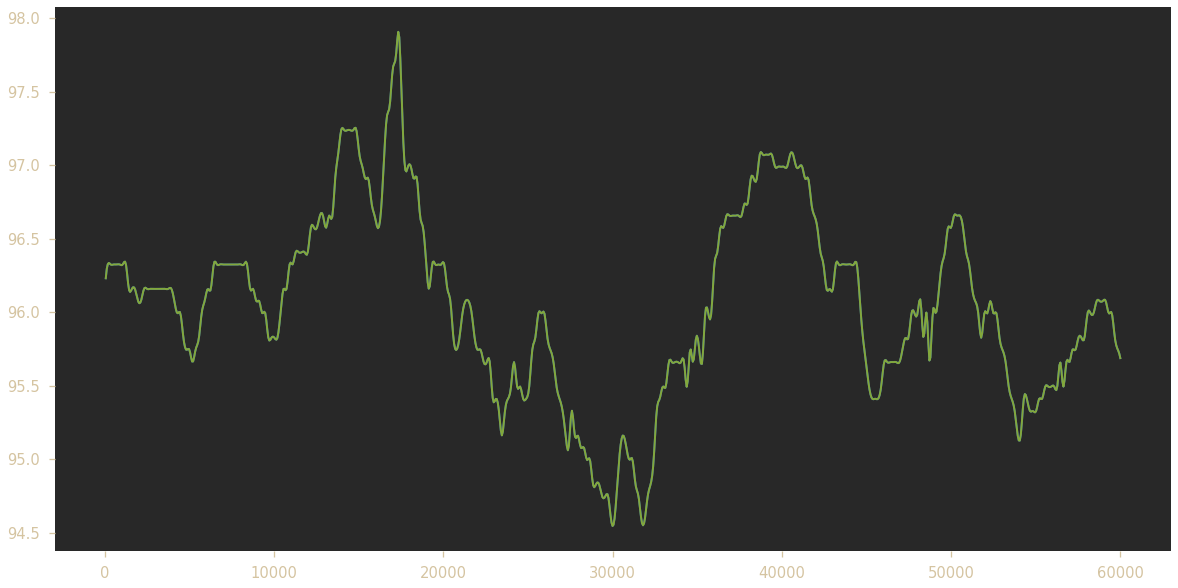

In [52]:
plt.rcParams['figure.figsize'] = [20, 10]
riser_supply = riser_supply_orig
riser_return = riser_return_orig
#plt.plot(riser_supply[-test_number:,0], y_test[:,-7,0])
#plt.plot(riser_return[-test_number:,0], y_test[:,0,1])
plt.plot(riser_supply[:-seq_length-forward_pred-test_number,0][0:1000], x_train[:,0,0][0:1000])
plt.plot(riser_return[:-seq_length-forward_pred-test_number,0][0:1000], x_train[:,0,0][0:1000])

#plt.plot(riser_supply[-test_number:,0], riser_supply[-test_number:,1])

#plt.plot(riser_return[-test_number:,0], riser_return[-test_number:,1])
plt.show()

### DNN Definition

In [57]:
REG_LSTM = 1e-9
REG_DENSE = 1e-10
LSTM_DROPOUT=0.15
DENSE_DROPOUT=0.0


input_temp_supply = Input(shape=(x_train_temperature_supply.shape[1], x_train_temperature_supply.shape[2]))
input_temp_return = Input(shape=(x_train_temperature_return.shape[1], x_train_temperature_return.shape[2]))
input_time = Input(shape=(x_train_quadrature.shape[1], x_train_quadrature.shape[2]))

time_proc2 = Dense(32, activation='tanh', activity_regularizer=l2(REG_DENSE))(input_time)
time_proc = Dense(8, activation='tanh', activity_regularizer=l2(REG_DENSE))(time_proc2)

merged = concatenate([input_temp_supply, input_temp_return, time_proc], axis=2)

lstm = Bidirectional(LSTM(128, activation='relu', return_sequences=True, dropout=LSTM_DROPOUT, activity_regularizer=l2(REG_LSTM)))(merged, training=True)
lstm = Bidirectional(LSTM(32, activation='relu', return_sequences=True, dropout=LSTM_DROPOUT, activity_regularizer=l2(REG_LSTM)))(lstm, training=True)

#rsh = Dropout(DENSE_DROPOUT)(Reshape(target_shape=(forward_pred,120//forward_pred*64))(lstm))
#rsh = Reshape(target_shape=(forward_pred,120//forward_pred*32))(lstm)
rsh = Flatten()(lstm)
rsh = Dropout(0.2)(rsh)
#dense = TimeDistributed(Dense(8, activation='relu', activity_regularizer=l2(REG_LSTM)))(rsh)


#lstm = LSTM(32, activation='relu', return_sequences=True, dropout=LSTM_DROPOUT, activity_regularizer=l2(REG_LSTM))(dense, training=True)
#lstm = LSTM(32, activation='relu', return_sequences=True, dropout=LSTM_DROPOUT, activity_regularizer=l2(REG_LSTM))(lstm, training=True)
#lstm = LSTM(1, activation='relu', return_sequences=True, dropout=LSTM_DROPOUT, activity_regularizer=l2(REG_LSTM))(lstm, training=True)

#out = TimeDistributed(Dense(1, activation='relu', activity_regularizer=l2(REG_LSTM)))(lstm)
dense = Dense(128, activation='relu', activity_regularizer=l2(REG_LSTM))(rsh)
#dense = Dense(128, activation='relu', activity_regularizer=l2(REG_LSTM))(dense)
dense = Dropout(0.2)(dense)

dense = Dense(64, activation='relu', activity_regularizer=l2(REG_LSTM))(dense)
#out10_del = Dense(forward_pred, activation='relu')(dense)
#out90_del = Dense(forward_pred, activation='relu')(dense)

out_supply = Dense(forward_pred, activation='relu', activity_regularizer=l2(REG_LSTM))(dense)
out_return = Dense(forward_pred, activation='relu', activity_regularizer=l2(REG_LSTM))(dense)


#out50 = Dense(forward_pred, activation='relu', name="output50")(dense)
#out10 = add([out50, out10_del], name="output10")
#out90 = add([out50, out90_del], name="output90")

#out10 = Dense(1,activation='tanh')(dense)
#dense = Dense(16,activation='relu')(lstm)
#out50 = Dense(5,activation='tanh')(dense)
#out90 = Dense(1,activation='tanh')(dense)
model = Model([input_temp_supply, input_temp_return, input_time], [out_supply, out_return])
#model = Model([input_temp, input_time],[out10, out50, out90])

def q_loss(q, y, f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

losses = [
    lambda y,f: q_loss(0.1, y, f),
    lambda y,f: q_loss(0.5,y,f),
    lambda y,f:q_loss(0.9,y,f)
]



sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mse', optimizer=adam)
#model.compile(loss='mse', optimizer=adam)
#model.compile(loss=losses, optimizer=adam)

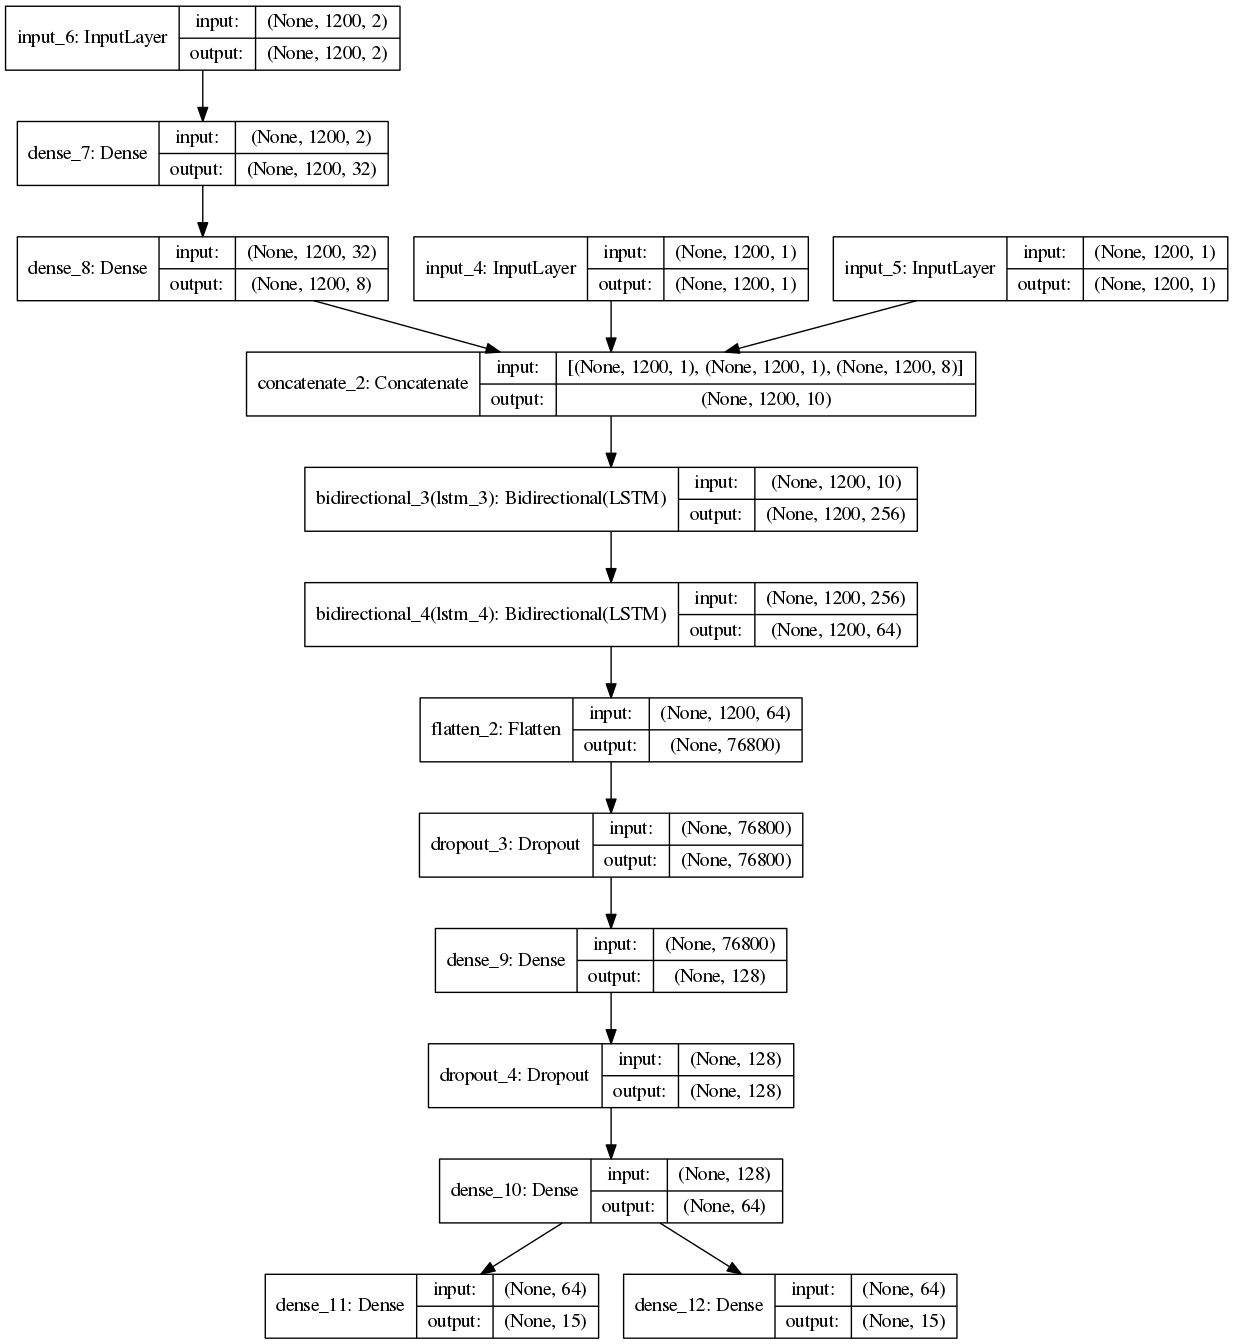

In [56]:
plt.rcParams['figure.figsize'] = [20, 20]

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=100)

#img = plt.imread('model_plot.png')
#f = plt.figure(figsize=(img.shape[1],img.shape[0]), dpi=300)
#plt.imshow(img)

In [ ]:
from datetime import datetime

logdir="/home/ubuntu/anomaly/tensorboard/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = k.callbacks.TensorBoard(log_dir=logdir)


history = model.fit(
    [x_train_temperature_supply, x_train_temperature_return, x_train_quadrature], 
    [y_train_supply, y_train_return], 
    epochs=25, 
    batch_size=seq_length*4,
    verbose=1,
    shuffle=True,
    validation_data=(
        [x_test_temperature_supply, x_test_temperature_return, x_test_quadrature], 
        [y_test_supply, y_test_return]
    ),
    callbacks=[tensorboard_callback],
)

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]

plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()



In [59]:
pred = model.predict([x_test_temperature_supply, x_test_temperature_return, x_test_quadrature], verbose=1, batch_size=seq_length*64)


W0808 17:33:13.910578 139753406441216 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2993: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[4126800,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node dense_13/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[dense_18/Relu/_239]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[4126800,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node dense_13/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

In [ ]:
pred[0].shape

In [ ]:
plt.rcParams['figure.figsize'] = [25, 15]
plt.plot(riser_supply[-test_number:,0], pred[0][:,0])
plt.plot(riser_supply[-test_number:,0], pred[1][:,0])
plt.plot(riser_supply[-test_number:,0], y_test_supply[:,0])
plt.plot(riser_supply[-test_number:,0], y_test_return[:,0])
plt.legend(["Predicted supply", "Predicted return", "Actual supply", "Actual return"])
#plt.xlim(4050500,4060000)
plt.show()

In [ ]:
folder = '/home/ubuntu/anomaly/saved_models/'
filename = 'quantile_v1_d2pred_SMALL'
model_json = model.to_json()
with open(folder+filename+'.json', 'w') as f:
    f.write(model_json)
    
model.save_weights(folder+filename+'.hdf5')
